In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import gin
import ddsp
from ddsp import spectral_ops, core
from IPython.display import Audio
import ipywidgets as widgets

import warnings
warnings.filterwarnings("ignore")

from utils import specplot
from composition.common import (
    oscillate, perc, adsr, silence, rescale, autotune, linear_oscillate
)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
sample_rate = 16000
hop_size = 64
step_dur = hop_size / sample_rate

In [3]:
def rebuild_model():
    model = pretrained.value

    # Pretrained models.
    PRETRAINED_DIR = f'pretrained/{model.lower()}'

    model_dir = PRETRAINED_DIR
    gin_file = os.path.join(model_dir, 'operative_config-0.gin')

    # Parse gin config,
    with gin.unlock_config():
        gin.parse_config_file(gin_file, skip_unknown=True)

    # Assumes only one checkpoint in the folder, 'ckpt-[iter]`.
    ckpt_files = [f for f in os.listdir(model_dir) if 'ckpt' in f]
    ckpt_name = ckpt_files[0].split('.')[0]
    ckpt = os.path.join(model_dir, ckpt_name)

    # Ensure dimensions and sampling rates are equal
    time_steps_train = gin.query_parameter('F0LoudnessPreprocessor.time_steps')
    n_samples_train = gin.query_parameter('Harmonic.n_samples')
    hop_size = int(n_samples_train / time_steps_train)

    time_steps = len(af['f0_hz'])
    n_samples = time_steps * hop_size

    gin_params = [
        'Harmonic.n_samples = {}'.format(n_samples),
        'FilteredNoise.n_samples = {}'.format(n_samples),
        'F0LoudnessPreprocessor.time_steps = {}'.format(time_steps),
        'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
    ]

    with gin.unlock_config():
        gin.parse_config(gin_params)


    # Set up the model just to predict audio given new conditioning
    model = ddsp.training.models.Autoencoder()
    model.restore(ckpt)

    # Build model by running a batch through it.
    _ = model(af, training=False)
    return model

In [18]:
def generate(pitch, loudness):
    af = {
        'f0_hz': librosa.midi_to_hz(pitch),
        'loudness_db': loudness
    }

    # ======== Processing ========

    # rebuild model
    model = rebuild_model()

    # generate audio
    outputs = model(af, training=False)
    audio_gen = model.get_audio_from_outputs(outputs).numpy()
    
    del model

    # play and show spectrogram
    play = Audio(audio_gen, rate=16000)
    display(play)
    specplot(audio_gen)
    _ = plt.title("Resynthesis")

    # show generation parameters (score)
    fig, ax = plt.subplots(nrows=2, 
                           ncols=1, 
                           sharex=True,
                           figsize=(12, 8))

    ax[0].plot(af['loudness_db'])
    ax[0].set_ylabel('loudness_db')

    ax[1].plot(librosa.hz_to_midi(af['f0_hz']))
    ax[1].set_ylabel('f0 [midi]')
    
    return audio_gen

In [25]:
pretrained = widgets.Dropdown(
    options=['violin', 'flute', 'flute2', 'cello', 'viola'],
    value='cello',
    description='Pretrained:',
    disabled=False,
)
display(pretrained)

Dropdown(description='Pretrained:', index=3, options=('violin', 'flute', 'flute2', 'cello', 'viola'), value='c…

- Violin 55-103
- Viola 48-91
- Cello 36-76
- Flute 60-96
- Flute2 55-91

23.088 seconds


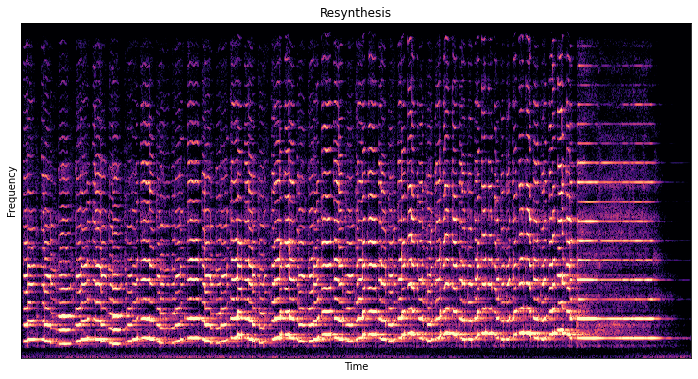

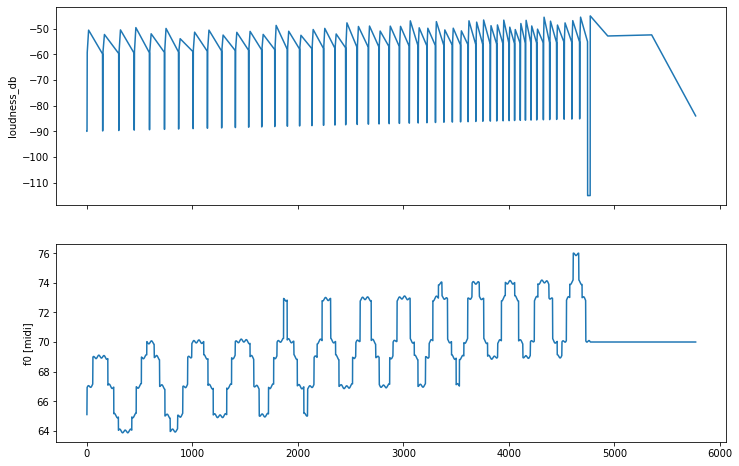

In [30]:
# ====== Loudness ======

loudness = []
dur = 0.6
delta = -0.01
for i in range(50):
    loudness.append(silence(0.01) - 90)
    loudness.append(rescale(perc(0.1, np.random.uniform(dur-0.02, dur+0.02), np.random.uniform(0.5, 1.0)), -60, -50))
    if dur > 0.6 or dur < 0.2:
        delta *= -1
    dur += delta
loudness.append(silence(0.1) - 120)
loudness.append(rescale(adsr(0., 0.2, 0.5, 0.5, 4, 1., 0.8), -90, -50))
loudness = np.concatenate(loudness)
loudness += np.linspace(0, 6, len(loudness))
    
# ====== Pitch ======

n_steps = len(loudness)
duration = n_steps * step_dur
print(f'{duration} seconds')

t = np.linspace(0, duration, n_steps)
pitch = linear_oscillate(t, 0.1, 0.5, 60+6, 3, 0, 1)

pitch += np.linspace(0, 8, n_steps)
pitch = autotune(pitch, 0.9, scale='harmonic_minor', rotate=0, offset=2)
pitch += oscillate(t, 5, 0, 0.1)
pitch[-1000:] = pitch[-1000]

# ====== Generate ======

audio = generate(pitch, loudness)